# ---------------------------------------------------------------------------------------------

## EA App category prediction 

### This python code constructs the Text Classification model, so the machine learns how to classify the issue type from user input Q11D.                                   
# ---------------------------------------------------------------------------------------------

In [134]:
pwd

'C:\\Users\\bshakeri\\DnA - Tasks\\EA APP Survey'

In [117]:
# pip install wordcloud

In [135]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [3]:
import joblib
import re
import string

In [4]:
import numpy as np
import pandas as pd

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.naive_bayes import MultinomialNB

## Loading the training/testing csv

In [136]:
df = pd.read_csv(r"C:\Users\bshakeri\DnA - Tasks\EA APP Survey\EA App Feedback Survey_20221101_MLTraining.csv", encoding= 'utf-8-sig')

In [38]:
df.head(1)

,record,uuid,date,markers,status,vlist,qtime,vos,vosr15oe,vbrowser,...,Q13r31,Q13r61,Q13r62,Q13r12,Q13r13,Q13r14,Q13r15,Q13r16,Q30,Q31
0,347106,6y0c81svmgbny0ez,11/01/2022 0:02,"qualified,/hQ11B/hWave_r2/hQ11B_13,/Overall/To...",3,1,211.345,4.0,NaN,10.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,删了他是最好的选择


In [39]:
df.columns

Index(['record', 'uuid', 'date', 'markers', 'status', 'vlist', 'qtime', 'vos',
       'vosr15oe', 'vbrowser',
       ...
       'Q13r31', 'Q13r61', 'Q13r62', 'Q13r12', 'Q13r13', 'Q13r14', 'Q13r15',
       'Q13r16', 'Q30', 'Q31'],
      dtype='object', length=187)

In [137]:
## Removing two outliers - the text is still in chineese
df = df[(df.record != 364773) & (df.record != 364777)]

## EDA for the Category variable

In [43]:
# Unique language
df['decLang'].unique()

array(['simplifiedchinese', 'usa', 'spanish', 'german', 'polish',
       'portuguese_br', 'french'], dtype=object)

In [58]:
df['Category'].unique()

array(['Game wouldn’t launch', 'Problems with download',
       'None of the above',
       'Issues with EA Play/EA Play Pro subscription',
       'App felt slow or laggy', 'Issues with login',
       'Game installation issues', 'Issues with chat or game invites',
       'Issues updating the EA app client', 'Issues linking accounts',
       'App crashes or freezes',
       'Couldn’t find game or DLC I was looking for',
       'Issues updating a game', 'Issues with purchasing'], dtype=object)

In [44]:
df['Category'].value_counts()

# df.Category.value_counts()

None of the above                               1389
Game wouldn’t launch                             499
Couldn’t find game or DLC I was looking for      259
Problems with download                           253
Issues with login                                248
Issues linking accounts                          245
App crashes or freezes                           230
Issues with purchasing                           199
Game installation issues                         154
App felt slow or laggy                           144
Issues with chat or game invites                 121
Issues updating the EA app client                106
Issues updating a game                            92
Issues with EA Play/EA Play Pro subscription      59
Name: Category, dtype: int64

In [45]:
# pd.DataFrame(df['Category'].value_counts()).reset_index()

counts = df.Category.value_counts()
percs = df.Category.value_counts(normalize=True)*100
pd.concat([counts,percs], axis=1, keys=['count', 'percentage'])

,count,percentage
None of the above,1389,34.742371
Game wouldn’t launch,499,12.481241
Couldn’t find game or DLC I was looking for,259,6.478239
Problems with download,253,6.328164
Issues with login,248,6.203102
Issues linking accounts,245,6.128064
App crashes or freezes,230,5.752876
Issues with purchasing,199,4.977489
Game installation issues,154,3.851926
App felt slow or laggy,144,3.601801


#### Takeaway: %35 of the commenters chose that cause of the error is not among the options. It would be interesting to see what they commented about it. 

## Clean the user input text

In [138]:
def process_text(text):
    text = str(text).lower()
    text = re.sub(
        f"[{re.escape(string.punctuation)}]", " ", text
    )
    text = " ".join(text.split())
    return text

In [139]:
df["clean_text"] = df.Q11D.map(process_text)

In [55]:
df.to_csv('df_cleantext.csv', index=False, encoding= 'utf-8-sig')
# df.head(5)

### Takeaway: The text is not clean enough >> need to try more 

### Analyze %35 of the comments chose "None of the above"

In [140]:
df_subset1 =  df[df["Category"] == 'None of the above']

# df_subset1.head()
df_subset1["clean_text"].tail(10)


3975                                                  nan
3977                                                  nan
3980                                                  nan
3985                                                  nan
3988                                                  nan
3989                           can t update online status
3992                                    the app is a joke
3995                                                   no
3996    start up and during run the app says it s not ...
3999                                                  nan
Name: clean_text, dtype: object

In [141]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# Question:
# there are a substantial number of "nan" > 
# does it mean that there was no error or simple the commented did not put anything?

n = df_subset1[df_subset1["clean_text"] == 'nan']["clean_text"].count()
m = np.round(n/1391*100,1)

print('There is {a} of null value on the comment section which is equal to %{b} of all none category.'.format(a=n, b=m))

There is 567 of null value on the comment section which is equal to %40.8 of all none category.


In [142]:
# removing "nan" values for the word cloud
df_subset2 = df_subset1[df_subset1["clean_text"] != 'nan']
print('# Number of comments after droping nan values: {}'.format(df_subset2["clean_text"].count()))

df_subset2 = df_subset2.dropna(subset=['clean_text'])
print('# Number of comments after droping null values: {}'.format(df_subset2["clean_text"].count()))


df_subset2 = df_subset2.loc[df_subset2['clean_text'].str.len() > 1]
print('# Number of comments after droping values less than 1 character: {}'.format(df_subset2["clean_text"].count()))

df_subset2.head(1)

# Number of comments after droping nan values: 822
# Number of comments after droping null values: 822
# Number of comments after droping values less than 1 character: 713


,record,uuid,date,markers,status,vlist,qtime,vos,vosr15oe,vbrowser,...,Q13r61,Q13r62,Q13r12,Q13r13,Q13r14,Q13r15,Q13r16,Q30,Q31,clean_text
3,347150,np4sw5d4y3xjuq0b,11/01/2022 0:27,"qualified,/Overall/Total,20220823_19:39_v32,/h...",3,1,307.028,4.0,NaN,10.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,NaN,尽快修复bug,game


In [143]:
text = " ".join(cat for cat in df_subset2.clean_text)
# print(text)

#### Let's try some tokenization

In [101]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bshakeri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\bshakeri\AppData\Roaming\nltk_data...


True

In [144]:
# There are three types of tokenizer
# WhitespaceTokenizer()
# TreebankWorkTokenizer()
# WordPunctTokenizer()

tokenizer = nltk.tokenize.TreebankWordTokenizer()

In [126]:
# ## Removing stop words

# stop_words = set(STOPWORDS)

# tokens0 = tokenizer.tokenize(text)

# # converts the words in word_tokens to lower case and then checks whether 
# #they are present in stop_words or not
# filtered_sentence = [w for w in tokens0 if not w.lower() in stop_words]
# #with no lower case conversion
# filtered_sentence = []
  
# for w in tokens0:
#     if w not in stop_words:
#         filtered_sentence.append(w)

# print(filtered_sentence)

In [119]:
# # What do lemmatization and stemming do? 

# text2 = "feet wolves cats talked"
# tokens = tokenizer.tokenize(text2)
# print(tokens)

# ## Lemmatization
# stemmer = nltk.stem.WordNetLemmatizer()
# text3 = " ".join(stemmer.lemmatize(token) for token in tokens2)
# print(text3)

# ## Stemming
# tokens3 = tokenizer.tokenize(text3)
# stemmer = nltk.stem.PorterStemmer()
# text4 = " ".join(stemmer.stem(token) for token in tokens3)
# print(text4)

In [145]:
## Lemmatization
tokens = tokenizer.tokenize(text)
stemmer = nltk.stem.WordNetLemmatizer()
text1 = " ".join(stemmer.lemmatize(token) for token in tokens)

### Didn't have a good result
## Stemming
# tokens1 = tokenizer.tokenize(text1)
# stemmer = nltk.stem.PorterStemmer()
# text3 = " ".join(stemmer.stem(token) for token in tokens1)

final_text = text1

In [127]:
# print(final_text)

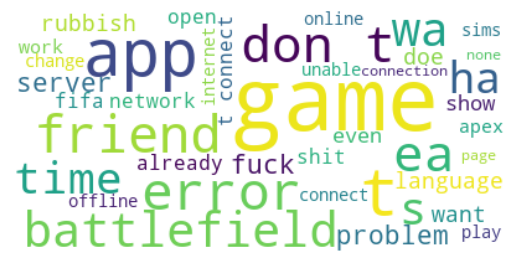

In [146]:
# Start with one review:
# text = df.description[0]

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(final_text)

# Display the generated image:
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
# plt.show()

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=70, max_words=40, background_color="white").generate(final_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


## Split the dataset into training set and testing set

In [147]:
# Main one > 
df_train, df_test = train_test_split(df, test_size=0.20, stratify=df.Category)

# Removing the "None of the above" Category
# df2 = df[df["Category"] != 'None of the above']
# df_train, df_test = train_test_split(df2, test_size=0.20, stratify=df2.Category)

In [29]:
#df_train.head()

## Create bags of words for text classification model

In [148]:
vec = CountVectorizer(
    ngram_range=(1, 3), 
    stop_words="english",
)

In [149]:
X_train = vec.fit_transform(df_train.clean_text)
X_test = vec.transform(df_test.clean_text)

In [36]:
# print(X_train)

In [150]:
y_train = df_train.Category
y_test = df_test.Category

## Training and evaluating the model

### 1. MultinominalNB

In [151]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [152]:
preds = nb.predict(X_test)
print(classification_report(y_test, preds))

                                              precision    recall  f1-score   support

                      App crashes or freezes       0.56      0.11      0.18        46
                      App felt slow or laggy       0.69      0.31      0.43        29
 Couldn’t find game or DLC I was looking for       0.58      0.27      0.37        52
                    Game installation issues       0.75      0.19      0.31        31
                        Game wouldn’t launch       0.37      0.96      0.53       100
                     Issues linking accounts       0.75      0.55      0.64        49
                      Issues updating a game       0.43      0.17      0.24        18
           Issues updating the EA app client       0.80      0.38      0.52        21
Issues with EA Play/EA Play Pro subscription       1.00      0.08      0.15        12
            Issues with chat or game invites       1.00      0.25      0.40        24
                           Issues with login       0.

## Save the model for future use

In [24]:
joblib.dump(nb, "nb.joblib")
joblib.dump(vec, "vec.joblib")

['vec.joblib']